In [3]:
import re
import numpy as np 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
from openTSNE import TSNE
from sklearn.decomposition import PCA

In [7]:
def keep_words_with_underscore(input_string):
    # Define a regular expression pattern to match words with underscores
    pattern = r'\b\w*_[\w_]*\b'

    # Use re.findall to extract words that match the pattern
    matching_words = re.findall(pattern, input_string)

    # Join the matching words to form the final string
    result = ' '.join(matching_words)

    return result

def flatten_matrix(matrix):
    flat = []
    for r in matrix:
        # for c in r:
        flat += r
    return np.unique(flat)


def compute_word_count_subset(corpus, subset_words):
    
    for document in tqdm(corpus):
        for word in document:
            if word in subset_words:
                subset_words[word] += 1
    return subset_words

In [5]:
ngram_abstracts = np.load("saved_files/ngram_abstracts.npy", mmap_mode="r")
concept_arr = np.unique(np.load("saved_files/overlapping_concepts.npy"))
year_arr = np.load("saved_files/year_arr.npy", mmap_mode="r")

In [9]:
# Compute word count for the subset of words 
word_count_subset = compute_word_count_subset([row.split() for row in ngram_abstracts], {k:0 for k in np.unique(concept_arr)})

def filter_dict_by_occurrence(word_count_dict, n):
    return {word: count for word, count in word_count_dict.items() if count > n}

filtered_concept_dict = np.array(list(filter_dict_by_occurrence(word_count_subset, 4).keys()))

ocurr_arr = {}
for abstract, year in tqdm(zip(ngram_abstracts, year_arr)):
    temp = keep_words_with_underscore(abstract)
    if year not in ocurr_arr:
        ocurr_arr[year] = []
    if temp.count(" ") > 0:
        temp = temp.split(" ") 
        temp = [s for s in temp if s in filtered_concept_dict]
        l = [list(filter(("_").__ne__, temp))]
        ocurr_arr[year].extend(l)

new_ocurr_arr = {}
for year in tqdm(np.unique(year_arr)):
    new_ocurr_arr[year] = flatten_matrix(ocurr_arr[year])

100%|██████████| 157821/157821 [00:00<00:00, 196038.43it/s]
157821it [00:46, 3402.56it/s]
100%|██████████| 31/31 [00:00<00:00, 52.12it/s] 


In [10]:
# Dictionary to store the first occurrence year of each word
first_occurrences = {}

# Dictionary to count the number of first occurrences per year
new_words_per_year = {}

# Iterate through the years in sorted order
for year in sorted(new_ocurr_arr.keys()):
    new_words_count = 0
    for word in new_ocurr_arr[year]:
        if word not in first_occurrences:
            first_occurrences[word] = year
            new_words_count += 1
    new_words_per_year[year] = new_words_count

years = sorted(new_words_per_year.keys())
cumulative_sum = [sum(new_words_per_year[y] for y in years if y <= year) for year in years]

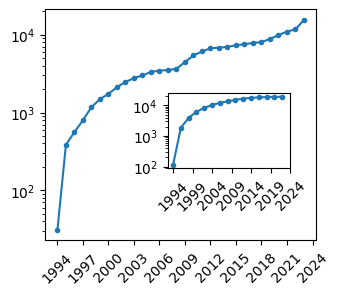

In [11]:
years, numpapers_y = np.unique(year_arr,return_counts=True)
fig, ax = plt.subplots(figsize=(3.5,3))

ax.plot( np.arange(len(numpapers_y))[:-1], numpapers_y[:-1], '-o', markersize=3 )
ax.set_xticks( list(range(len(years))[::3]))
ax.set_xticklabels( years[::3], rotation=45 )
ax.set_yscale("log")

ax2 = fig.add_axes([0.475, 0.25+0.1, 0.25+0.1, 0.25])
ax2.plot(np.arange(len(numpapers_y))[:-1][::2], cumulative_sum[:-1][::2], '-o', markersize=3)

ax2.set_xticks( list(range(len(years))[::5]))
ax2.set_xticklabels( years[::5], rotation=45 )
ax2.set_yscale("log")

### Latent Encoding 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
# sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import pandas as pd 

In [35]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_




model = Word2Vec.load("saved_models/model_year_{}.model".format(2023)) 
encoding_arr = np.array([model.wv.get_vector(w) for w in filtered_concept_dict])

In [36]:
clustering, cluster_labels = mbkmeans_clusters(
	X=encoding_arr,
    k=50,
    mb=500,
    print_silhouette_values=True,
)

/home/felix/vscodeProjects/arxiv_nlp/arxiv_venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 50
Silhouette coefficient: -0.10
Inertia:13619427.0
Silhouette values:
    Cluster 46: Size:3672 | Avg:0.09 | Min:0.02 | Max: 0.17
    Cluster 45: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 2: Size:1328 | Avg:-0.05 | Min:-0.12 | Max: 0.02
    Cluster 36: Size:811 | Avg:-0.10 | Min:-0.21 | Max: 0.01
    Cluster 11: Size:1563 | Avg:-0.11 | Min:-0.23 | Max: -0.01
    Cluster 21: Size:829 | Avg:-0.11 | Min:-0.23 | Max: -0.00
    Cluster 18: Size:814 | Avg:-0.12 | Min:-0.26 | Max: -0.00
    Cluster 48: Size:244 | Avg:-0.13 | Min:-0.30 | Max: 0.04
    Cluster 41: Size:196 | Avg:-0.14 | Min:-0.34 | Max: 0.03
    Cluster 9: Size:102 | Avg:-0.15 | Min:-0.45 | Max: -0.03
    Cluster 26: Size:108 | Avg:-0.15 | Min:-0.42 | Max: 0.03
    Cluster 15: Size:305 | Avg:-0.15 | Min:-0.37 | Max: -0.02
    Cluster 34: Size:134 | Avg:-0.16 | Min:-0.37 | Max: -0.02
    Cluster 32: Size:189 | Avg:-0.16 | Min:-0.39 | Max: -0.01
    Cluster 6: Size:256 | Avg:-0.16 | Min:-0.31 | Max: -

Most representative terms per cluster (based on centroids):
Cluster 0: molecule hyperfine spectroscopic 
Cluster 1: quantum_gate single_qubit_operation quantum_logic_gate 
Cluster 2: nanoscale diamond nanoscale_quantum_sensing 
Cluster 3: discontinuous_phase_transition phase_transition second_order_phase_transition 
Cluster 4: second_order_correlation_function analytical_expression expression 
Cluster 5: quantum_computer quantum_computing quantum_algorithm 
Cluster 6: emitter quantum_emitter single_quantum_emitter 
Cluster 7: sum_frequency_generation nonlinear_waveguide nonlinear_crystal 
Cluster 8: schroedinger_equation eigenfunctions bound_state_energy 
Cluster 9: distinct_quantum_phase spin_liquid_phase quantum_phase_transition 
Cluster 10: high_dimensional_tensor tensor_network quantic 
Cluster 11: algorithm quantum_algorithm quantum_circuit 
Cluster 12: estimation tomography quantum_state_estimation 
Cluster 13: bose_einstein_condensate matter_wave cold_atom 
Cluster 14: quantizat

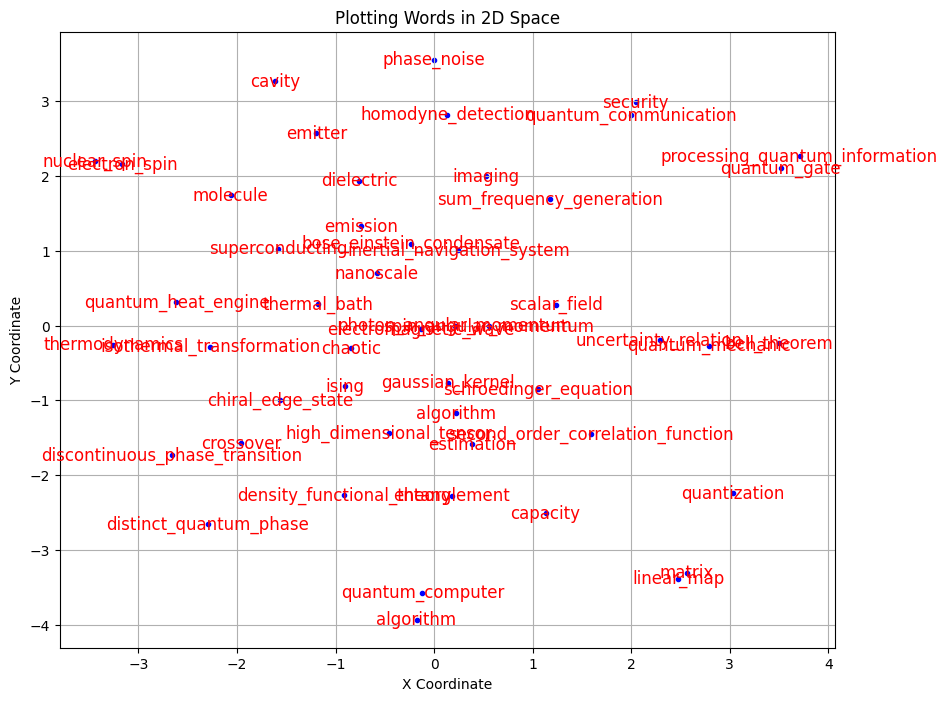

In [43]:
print("Most representative terms per cluster (based on centroids):")
vec_arr = []
word_arr = []
for i in range(50):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=3)
    vec_arr.append(clustering.cluster_centers_[i])
    word_arr.append(most_representative[0][0])
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")
vec_arr = np.array(vec_arr)
word_arr = np.array(word_arr)

embed = TSNE(n_components=2, random_state=42, perplexity=10,n_iter=1000).fit(vec_arr)
x_coords = embed[:,0]
y_coords = embed[:,1]

# Create the plot
plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, color='blue', marker='.')

# Plot each word at its respective coordinate
for (x, y), word in zip(embed, word_arr):
    plt.text(x, y, word, fontsize=12, ha='center', va='center', color='red')

# Set plot titles and labels
plt.title('Plotting Words in 2D Space')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Show grid
plt.grid(True)

# Show plot
plt.show()

(50, 2)


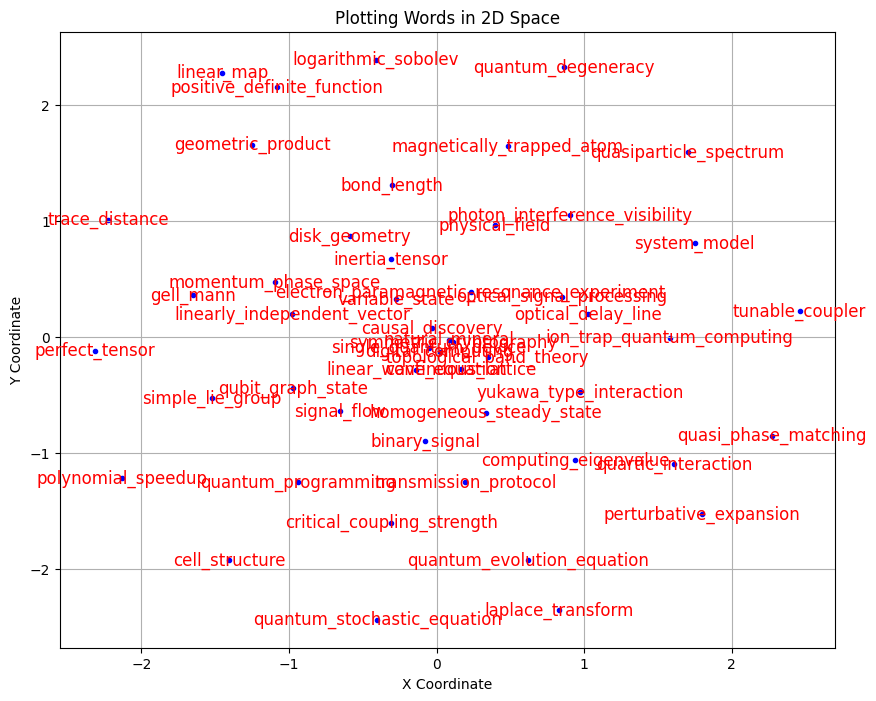

In [34]:
import matplotlib.pyplot as plt
from openTSNE import TSNE

def plot_words_in_2d_space(words):
    """
    Plots each word at its respective 2D coordinate.
    
    Parameters:
    coordinates (list of tuples): List of (x, y) pairs where each word should be plotted.
    words (list of str): List of words to be plotted at each coordinate.
    """

    plt.figure(figsize=(10, 8))
    for year in np.unique(year_arr):
        Word2Vec.load("saved_models/model_year_{}.model".format(year))
        vec_arr = []
        for cnt, w in enumerate(words):
            vec_arr.append(model.wv.get_vector(w))
        vec_arr = np.array(vec_arr)
        
        embed = TSNE(n_components=2, random_state=42, perplexity=10,n_iter=1000).fit(vec_arr)
            
    
        # Extract x and y coordinates
        x_coords = embed[:,0]
        y_coords = embed[:,1]
        
        # Create the plot
        
        plt.scatter(x_coords, y_coords, color='blue', marker='.')
        
        # Plot each word at its respective coordinate
        for (x, y), word in zip(embed, words):
            plt.text(x, y, word, fontsize=12, ha='center', va='center', color='red')
    



    # Set plot titles and labels
    plt.title('Plotting Words in 2D Space')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    
    # Show grid
    plt.grid(True)
    
    # Show plot
    plt.show()



plot_words_in_2d_space(np.random.choice(filtered_concept_dict,50))

Latent Encoding Time 

In [1]:
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from openTSNE import TSNE
from gensim.models import Word2Vec

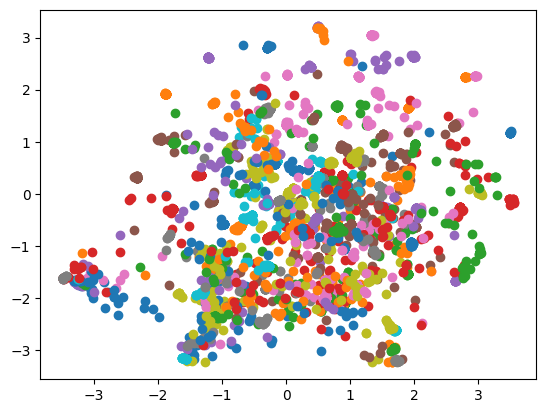

In [6]:
encoding_dat = np.load("c_encoding_arr.npy")
c_inx_arr = np.load("c_inx_arr.npy")

loaded_w2v = Word2Vec.load("saved_models/model_year_{}.model".format(2023))
word_list = np.array(loaded_w2v.wv.most_similar("phase_transition", topn=200))[:,0]
sel_inx = [np.where(c_inx_arr==word_)[0] for word_ in word_list]
sel_inx = np.array([arr for arr in sel_inx if arr.size > 0])[:,0]

# sel_inx = np.random.randint(len(encoding_dat),size=100)
random_choice_encoding = encoding_dat[sel_inx]
random_choice_concepts = c_inx_arr[sel_inx]

y_arr = []
embed = TSNE(n_components=2, random_state=42, perplexity=10,n_iter=1000).fit(random_choice_encoding[:,0,:])
for inx in range(len(np.unique(year_arr))):
    Y = embed.transform(random_choice_encoding[:,inx,:])
    y_arr.append(Y)
    

y_arr = np.array(y_arr) 
for i in range(len(sel_inx)):
    plt.scatter(y_arr[:,i,0], y_arr[:,i,1])#, c=np.unique(year_arr))
    

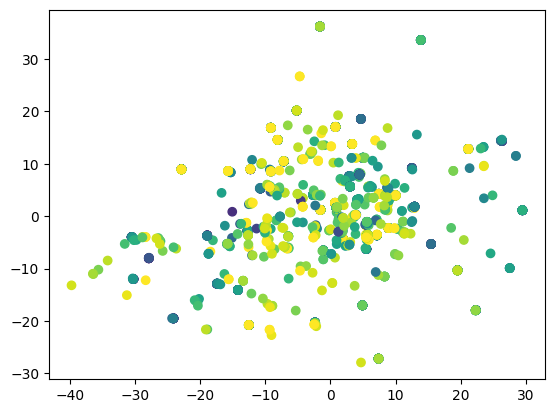

In [9]:
encoding_dat = np.load("c_encoding_arr.npy")
c_inx_arr = np.load("c_inx_arr.npy")

sel_inx = np.random.randint(len(encoding_dat),size=500)
random_choice_encoding = encoding_dat[sel_inx]
random_choice_concepts = c_inx_arr[sel_inx]
y_arr = []
embed = TSNE(n_components=2, random_state=42, perplexity=5,n_iter=1000).fit(random_choice_encoding[:,0,:])
for inx in range(len(np.unique(year_arr))):
    Y = embed.transform(random_choice_encoding[:,inx,:])
    y_arr.append(Y)
    
y_arr = np.array(y_arr) 
for i in range(50):
    plt.scatter(y_arr[:,i,0], y_arr[:,i,1], c=np.unique(year_arr))

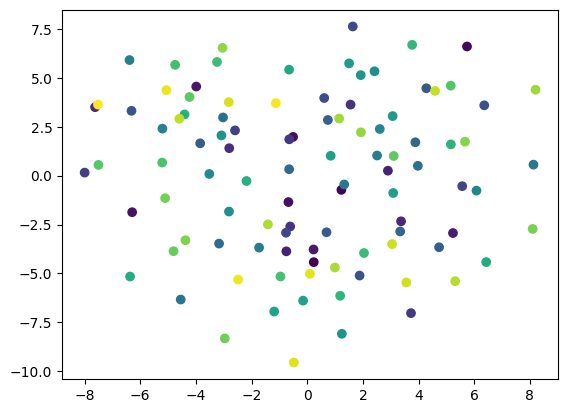

In [8]:
from openTSNE import TSNE
from sklearn.decomposition import PCA

encoding_dat = np.load("c_encoding_arr.npy")
c_inx_arr = np.load("c_inx_arr.npy")

sel_inx = np.random.randint(len(encoding_dat),size=100)
random_choice_encoding = encoding_dat[sel_inx]
random_choice_concepts = c_inx_arr[sel_inx]

Y = TSNE(n_components=2, random_state=42, perplexity=5,n_iter=100).fit(random_choice_encoding[:,0,:])

plt.scatter(Y[:,0], Y[:,1], c=np.arange(100))

In [ ]:
years, numpapers_y = np.unique(year_arr,return_counts=True)
fig, ax = plt.subplots(figsize=(3.5,3))

ax.plot( np.arange(len(numpapers_y))[:-1], numpapers_y[:-1], '-o', markersize=3 )
ax.set_xticks( list(range(len(years))[::3]))
ax.set_xticklabels( years[::3], rotation=45 )
ax.set_yscale("log")

ax2 = fig.add_axes([0.475, 0.25+0.1, 0.25+0.1, 0.25])
ax2.plot(np.arange(len(numpapers_y))[:-1][::2], cumulative_sum[:-1][::2], '-o', markersize=3)

ax2.set_xticks( list(range(len(years))[::5]))
ax2.set_xticklabels( years[::5], rotation=45 )
ax2.set_yscale("log")